# Titanic Survival Prediction

1. [Import Libraries](#heading1)
2. [Read Data](#heading2)
3. [Data Cleaning & Feature Engineering](#heading3)
4. [Exploratory Data Analysis](#heading4)
5. [Model Building & Evaluation](#heading5)
  * [Logistic Regression](#subheading1)
  * [Gaussian Naive Bayes](#subheading2)
  * [Linear Discriminant Analysis (LDA)](#subheading3)
  * [k Nearest Neighbors (kNN)](#subheading4)
  * [Support Vector Machine (SVM)](#subheading5)
  * [Decision Tree](#subheading6)
  * [Random Forest](#subheading7)
  * [XGBoost](#subheading8)
  * [Model Stacking](#subheading9)
  * [Result Comparison](#subheading10)
6. [Conclusion](#heading6)

# 1. Import Libraries <a id="heading1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [3]:
# Set seed value for reproducing the same results
seed = 101

# 2. Read Data <a id="heading2"></a>

In [4]:
train_data = pd.read_csv("../../Data/train.csv")
test_data = pd.read_csv("../../Data/train.csv")

In [5]:
# Train data preview
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [6]:
# Test data preview
test_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

We can see that the 'Survived' column is missing in the test set. We have to predict that label for each passenger in the test data.

In [7]:
# Summary of train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# Summary of test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 3. Data Cleaning & Feature Engineering <a id="heading3"></a>

In [9]:
# Train data descriptive statistics
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [10]:
# Test data descriptive statistics
test_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

For both train and test datasets, the statistics for 'Fare' column seem a bit strange. The minimum fare is 0 and the maximum is around 512, with 75% of values less than 31.5 and the mean being 35.6. We need to analyze this further to see if there are any outliers.

For this purpose, we can make use of a boxplot. It will help us understand the variation in the 'Fare' values by visually displaying the distribution of the data points.

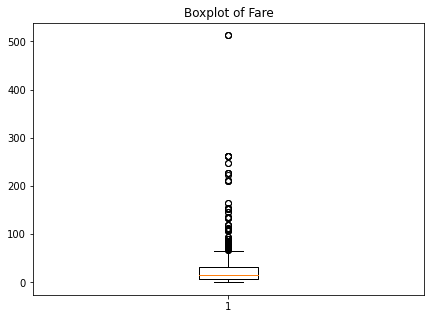

In [11]:
plt.subplots(figsize=(7, 5))
plt.boxplot(train_data['Fare'])
plt.title('Boxplot of Fare')
plt.show()

It seems like there are a few extreme data points. Let's explore this further.

In [12]:
# Retrieve rows with Fare greater than 500
train_data[train_data['Fare']>500]

PassengerId  Survived  Pclass                                Name  \
258          259         1       1                    Ward, Miss. Anna   
679          680         1       1  Cardeza, Mr. Thomas Drake Martinez   
737          738         1       1              Lesurer, Mr. Gustave J   

        Sex   Age  SibSp  Parch    Ticket      Fare        Cabin Embarked  
258  female  35.0      0      0  PC 17755  512.3292          NaN        C  
679    male  36.0      0      1  PC 17755  512.3292  B51 B53 B55        C  
737    male  35.0      0      0  PC 17755  512.3292         B101        C

Since all of the passengers have the same ticket number, we can conclude that the fare was calculated for the entire group and not each individual. Hence, we will not discard these rows.

To standardize the fare calculation across all passengers in the dataset, the obvious step would be to divide fare by the number of people on the same ticket and get the individual fare. But factors such as reduced fares for children, missing values, etc., will further complicate things. Therefore, we will leave it as it is. For an in-depth understanding of the titanic dataset (particularly fare calculation), you can explore [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/).

Before we proceed further, we also need to analyze passengers who had 0 fare.

In [13]:
# Retrieve rows with Fare equal to 0
train_data[train_data['Fare']==0]

PassengerId  Survived  Pclass                              Name   Sex  \
179          180         0       3               Leonard, Mr. Lionel  male   
263          264         0       1             Harrison, Mr. William  male   
271          272         1       3      Tornquist, Mr. William Henry  male   
277          278         0       2       Parkes, Mr. Francis "Frank"  male   
302          303         0       3   Johnson, Mr. William Cahoone Jr  male   
413          414         0       2    Cunningham, Mr. Alfred Fleming  male   
466          467         0       2             Campbell, Mr. William  male   
481          482         0       2  Frost, Mr. Anthony Wood "Archie"  male   
597          598         0       3               Johnson, Mr. Alfred  male   
633          634         0       1     Parr, Mr. William Henry Marsh  male   
674          675         0       2        Watson, Mr. Ennis Hastings  male   
732          733         0       2              Knight, Mr. Robert J  male   
806          807         0       1            Andrews, Mr. Thomas Jr  male   
815          816         0       1                  Fry, Mr. Richard  male   
822          823         0       1   Reuchlin, Jonkheer. John George  male   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
179  36.0      0      0    LINE   0.0   NaN        S  
263  40.0      0      0  112059   0.0   B94        S  
271  25.0      0      0    LINE   0.0   NaN        S  
277   NaN      0      0  239853   0.0   NaN        S  
302  19.0      0      0    LINE   0.0   NaN        S  
413   NaN      0      0  239853   0.0   NaN        S  
466   NaN      0      0  239853   0.0   NaN        S  
481   NaN      0      0  239854   0.0   NaN        S  
597  49.0      0      0    LINE   0.0   NaN        S  
633   NaN      0      0  112052   0.0   NaN        S  
674   NaN      0      0  239856   0.0   NaN        S  
732   NaN      0      0  239855   0.0   NaN        S  
806  39.0      0      0  112050   0.0   A36        S  
815   NaN      0      0  112058   0.0  B102        S  
822  38.0      0      0   19972   0.0   NaN        S

Again, it looks like there are no data errors; just some passengers who got a free ride for whatever reason (visit Encyclopedia Titanica if you're interested to find out why).

Next, we will check for missing values.

In [14]:
# Number of missing values in each column in train data
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
# Number of missing values in each column in test data
test_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

First, let's deal with the missing 'Age' values. For that purpose, we will first extract title of each passenger from their name.

In [16]:
# Function to extract title from passenger's name
def extract_title(df):
    title = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
    return title

In [17]:
# Count of each title in train data
train_data['Title'] = extract_title(train_data)
train_data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Don               1
the Countess      1
Lady              1
Jonkheer          1
Sir               1
Ms                1
Mme               1
Capt              1
Name: Title, dtype: int64

In [18]:
# Count of each title in test data
test_data['Title'] = extract_title(test_data)
test_data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Don               1
the Countess      1
Lady              1
Jonkheer          1
Sir               1
Ms                1
Mme               1
Capt              1
Name: Title, dtype: int64

Since there are many titles with very few counts, we will map them to main categories (titles that are more frequently occurring).

In [19]:
# Function to map titles to main categories
def map_title(df):
    title_category = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Dona": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
    }
    new_title = df['Title'].map(title_category)
    return new_title

In [20]:
# Count of each title in train data after mapping
train_data['Title'] = map_title(train_data)
train_data['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

In [21]:
# Count of each title in test data after mapping
test_data['Title'] = map_title(test_data)
test_data['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

Now that we have extracted titles from names, we can group data by title and impute missing age values using the median age of each category. We will also group by 'Pclass' as it will help in accurately calculating the median age within each class.

Note: We are using median value instead of mean because extreme values (or outliers) have a lot more impact on mean than median.

In [22]:
# Group train data by 'Pclass', 'Title' and calculate the median age
train_data.groupby(['Pclass', 'Title']).median()['Age']

Pclass  Title  
1       Master      4.0
        Miss       30.0
        Mr         40.0
        Mrs        40.0
        Officer    50.0
        Royalty    40.0
2       Master      1.0
        Miss       24.0
        Mr         31.0
        Mrs        31.5
        Officer    46.5
3       Master      4.0
        Miss       18.0
        Mr         26.0
        Mrs        31.0
Name: Age, dtype: float64

One thing to note here is that unlike the 'Master' title, there is no separate category for young female passengers. If we go back and look at the original dataset, we will realize that the 'Miss' title includes both young and adult females. We can somewhat solve this by identifying passengers with 'Miss' title having 1 or 2 value in the 'Parch' column. This way we can retrieve passengers who are most likely, young females (there's also a small chance that the retrieved passenger is a female adult because the 'Parch' column not only reveals the number of parents but also the number of children).

In [23]:
# Function to identify passengers who have the title 'Miss' and, 1 or 2 value in the 'Parch' column
def is_young(df):
    young = []
    for index, value in df['Parch'].items():
        if ((df.loc[index, 'Title'] == 'Miss') and (value == 1 or value == 2)):
            young.append(1)
        else:
            young.append(0)
    return young

In [24]:
# Group train data by 'Pclass', 'Title', 'Is_Young(Miss)' and calculate the median age
train_data['Is_Young(Miss)'] = is_young(train_data)
grouped_age = train_data.groupby(['Pclass', 'Title', 'Is_Young(Miss)']).median()['Age']
grouped_age

Pclass  Title    Is_Young(Miss)
1       Master   0                  4.0
        Miss     0                 31.0
                 1                 20.0
        Mr       0                 40.0
        Mrs      0                 40.0
        Officer  0                 50.0
        Royalty  0                 40.0
2       Master   0                  1.0
        Miss     0                 30.0
                 1                  7.0
        Mr       0                 31.0
        Mrs      0                 31.5
        Officer  0                 46.5
3       Master   0                  4.0
        Miss     0                 21.0
                 1                  5.0
        Mr       0                 26.0
        Mrs      0                 31.0
Name: Age, dtype: float64

This looks better as we can now guess the missing age values more accurately than before. We will apply this function to the test data as well.

In [25]:
test_data['Is_Young(Miss)'] = is_young(test_data)

Next, we will impute the missing age values according to the grouped data shown above.

In [26]:
# Fill missing age values in train and test data
train_data.set_index(['Pclass', 'Title', 'Is_Young(Miss)'], drop=False, inplace=True)
train_data['Age'].fillna(grouped_age, inplace=True)
train_data.reset_index(drop=True, inplace=True)
test_data.set_index(['Pclass', 'Title', 'Is_Young(Miss)'], drop=False, inplace=True)
test_data['Age'].fillna(grouped_age, inplace=True)
test_data.reset_index(drop=True, inplace=True)

A very important thing that needs to be addressed is that I've only used the train data to calculate the median ages for replacing missing values in both train and test datasets. Many people, especially those participating in data science competitions, use test data as well for preprocessing purposes. This may help people improve their model's test accuracy and rank higher in competitions, but it is considered a major mistake in real world applications (known as **data leakage**). Models built using this approach do not generalize too well to the new/unseen data and give results that are a lot poorer than expected. Hence, test data should never be used for data preprocessing and should only be used for testing purposes.

For replacing the missing 'Fare' value in test data, we will simply group the train data by 'Pclass' and repeat the same steps as above.

In [27]:
# Group train data by 'Pclass' and calculate the median fare
grouped_fare = train_data.groupby('Pclass').median()['Fare']
grouped_fare

Pclass
1    60.2875
2    14.2500
3     8.0500
Name: Fare, dtype: float64

In [28]:
# Fill the missing fare value in test data
test_data.set_index('Pclass', drop=False, inplace=True)
test_data['Fare'].fillna(grouped_fare, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Finally, we will drop all of the unnecessary rows and columns:
* Name: We've extracted the information that we needed (i.e. Title) and don't need this column anymore
* Cabin: Majority of the values are missing so we will drop the entire column
* Embarked: Only 2 values are missing in train data so we can just remove those 2 entire rows
* Ticket: Doesn't seem to provide any useful information so we will drop the entire column
* Is_Young(Miss): Purpose of creating this column has been fulfilled and we don't need it anymore

In [29]:
# Drop unnecessary rows and columns
train_data.drop(columns=['Name', 'Cabin', 'Ticket', 'Is_Young(Miss)'], inplace=True)
test_data.drop(columns=['Name', 'Cabin', 'Ticket', 'Is_Young(Miss)'], inplace=True)
train_data.dropna(subset=['Embarked'], inplace=True)

It is always good to verify that there are no remaining missing values.

In [30]:
# Missing values in train data after data cleaning
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64

In [31]:
# Missing values in test data after data cleaning
test_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
Title          0
dtype: int64

# 4. Exploratory Data Analysis <a id="heading4"></a>

In this section, we will try to find some interesting insights using visual methods.

First, we will look at the class distribtuion.

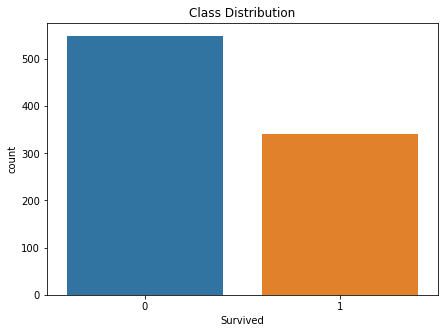

In [32]:
plt.subplots(figsize=(7, 5))
sns.countplot(x='Survived', data=train_data)
plt.title('Class Distribution')
plt.show()

We can clearly see that the classes are slightly imbalanced since majority of the passengers did not survive. In scenarios like this, the same ratio is expected in test data so we don't need to worry about the imbalanced classes.

Next, let's find out the ratio of survivors with respect to other variables (i.e. 'Sex', 'Pclass', 'Embarked', 'Title').

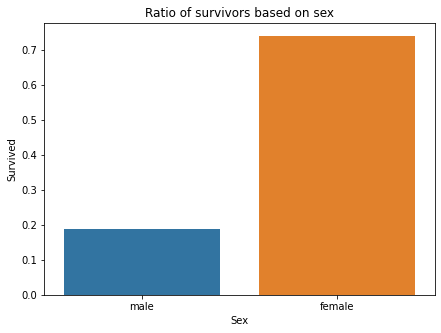

In [33]:
plt.subplots(figsize=(7, 5))
sns.barplot(x='Sex', y='Survived', data=train_data, ci=None)
plt.title('Ratio of survivors based on sex')
plt.show()

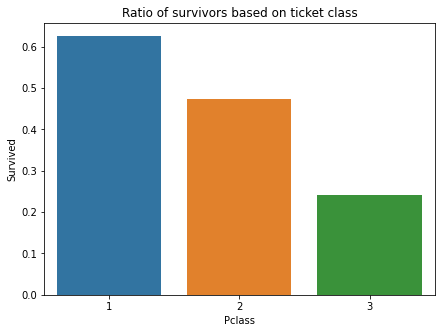

In [34]:
plt.subplots(figsize=(7, 5))
sns.barplot(x='Pclass', y='Survived', data=train_data, ci=None)
plt.title('Ratio of survivors based on ticket class')
plt.show()

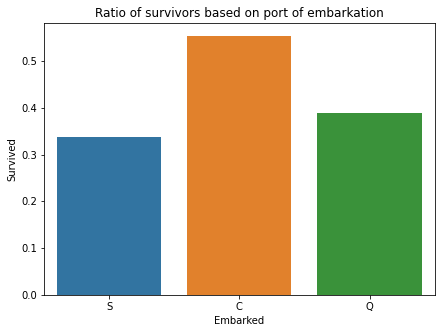

In [35]:
plt.subplots(figsize=(7, 5))
sns.barplot(x='Embarked', y='Survived', data=train_data, ci=None)
plt.title('Ratio of survivors based on port of embarkation')
plt.show()

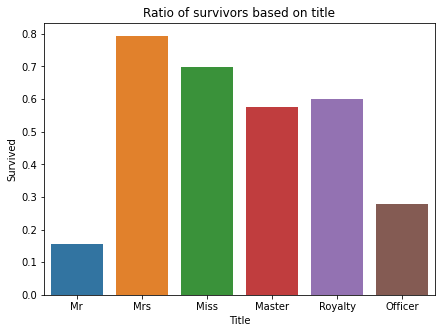

In [36]:
plt.subplots(figsize=(7, 5))
sns.barplot(x='Title', y='Survived', data=train_data, ci=None)
plt.title('Ratio of survivors based on title')
plt.show()

Based on these visualizations, we can conclude the following:
* Females had a way higher survival rate than males
* Lower ticket class (with 3 being the lowest) means less chance of survival
* Passengers who embarked from port 'C' had slightly more chances of survival
* Passengers with the title 'Mr' and 'Officer' had really low chances of survival as compared to other passengers

Note: The accuracy of these findings also depends on other factors such as the frequency distribution within each categorical variable. For example, if there is only 1 female in the entire dataset and she survived, then the survival rate of females will be 100% which cannot be considered a concrete finding. Hence, depending on the type of problem being solved, further data analysis should be done if required.

Next, we will compute the pairwise correlation of different variables, focusing mainly on how different features correlate with the target variable 'Survived'. But first, we need to convert all of the categorical variables into numeric data type.

To convert 'Sex' variable into numeric format, we will simply encode male with 1 and female with 0.

In [37]:
# Encode 'Sex' variable values
le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])
test_data['Sex'] = le.transform(test_data['Sex'])

For 'Embarked' and 'Title' variables, we will use dummy variables to represent different values.

In [38]:
# Convert 'Embarked' and 'Title' into dummy variables
train_data = pd.get_dummies(train_data, columns=['Embarked', 'Title'])
test_data = pd.get_dummies(test_data, columns=['Embarked', 'Title'])

This is how the dataset looks like after conversion:

In [39]:
train_data.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    1  22.0      1      0   7.2500   
1            2         1       1    0  38.0      1      0  71.2833   
2            3         1       3    0  26.0      0      0   7.9250   
3            4         1       1    0  35.0      1      0  53.1000   
4            5         0       3    1  35.0      0      0   8.0500   

   Embarked_C  Embarked_Q  Embarked_S  Title_Master  Title_Miss  Title_Mr  \
0           0           0           1             0           0         1   
1           1           0           0             0           0         0   
2           0           0           1             0           1         0   
3           0           0           1             0           0         0   
4           0           0           1             0           0         1   

   Title_Mrs  Title_Officer  Title_Royalty  
0          0              0              0  
1          1              0              0  
2          0              0              0  
3          1              0              0  
4          0              0              0

Finally, we can calculate the correlation.

In [40]:
# Pairwise correlation of columns
corr = train_data.corr()
corr

PassengerId  Survived    Pclass       Sex       Age     SibSp  \
PassengerId       1.000000 -0.005028 -0.035330  0.043136  0.035304 -0.057686   
Survived         -0.005028  1.000000 -0.335549 -0.541585 -0.055756 -0.034040   
Pclass           -0.035330 -0.335549  1.000000  0.127741 -0.412684  0.081656   
Sex               0.043136 -0.541585  0.127741  1.000000  0.111186 -0.116348   
Age               0.035304 -0.055756 -0.412684  0.111186  1.000000 -0.299570   
SibSp            -0.057686 -0.034040  0.081656 -0.116348 -0.299570  1.000000   
Parch            -0.001657  0.083151  0.016824 -0.247508 -0.199577  0.414542   
Fare              0.012703  0.255290 -0.548193 -0.179958  0.113625  0.160887   
Embarked_C       -0.001208  0.169966 -0.245733 -0.084520  0.049316 -0.060074   
Embarked_Q       -0.033694  0.004536  0.220558 -0.075217 -0.086584 -0.026692   
Embarked_S        0.022269 -0.151777  0.076466  0.121405  0.011295  0.069438   
Title_Master     -0.026218  0.085998  0.081547  0.159612 -0.392649  0.349434   
Title_Miss       -0.064014  0.332094 -0.006737 -0.692363 -0.305175  0.085939   
Title_Mr          0.039008 -0.547689  0.139156  0.866888  0.215257 -0.252201   
Title_Mrs         0.005437  0.343836 -0.151780 -0.552629  0.191443  0.061261   
Title_Officer     0.055440 -0.030963 -0.149428  0.088976  0.189013 -0.024872   
Title_Royalty     0.031681  0.033666 -0.118241 -0.007728  0.069560 -0.008467   

                  Parch      Fare  Embarked_C  Embarked_Q  Embarked_S  \
PassengerId   -0.001657  0.012703   -0.001208   -0.033694    0.022269   
Survived       0.083151  0.255290    0.169966    0.004536   -0.151777   
Pclass         0.016824 -0.548193   -0.245733    0.220558    0.076466   
Sex           -0.247508 -0.179958   -0.084520   -0.075217    0.121405   
Age           -0.199577  0.113625    0.049316   -0.086584    0.011295   
SibSp          0.414542  0.160887   -0.060074   -0.026692    0.069438   
Parch          1.000000  0.217532   -0.011588   -0.081585    0.061512   
Fare           0.217532  1.000000    0.270731   -0.116684   -0.163758   
Embarked_C    -0.011588  0.270731    1.000000   -0.148646   -0.782613   
Embarked_Q    -0.081585 -0.116684   -0.148646    1.000000   -0.499261   
Embarked_S     0.061512 -0.163758   -0.782613   -0.499261    1.000000   
Title_Master   0.267194  0.011390   -0.035471    0.010330    0.024577   
Title_Miss     0.103551  0.119660    0.038498    0.169631   -0.140514   
Title_Mr      -0.335765 -0.181692   -0.073976   -0.079283    0.114726   
Title_Mrs      0.223240  0.103920    0.067462   -0.090739   -0.001989   
Title_Officer -0.048377  0.010679   -0.008192    0.012520   -0.000704   
Title_Royalty -0.035673  0.015222    0.078960   -0.023159   -0.054604   

               Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Officer  \
PassengerId       -0.026218   -0.064014  0.039008   0.005437       0.055440   
Survived           0.085998    0.332094 -0.547689   0.343836      -0.030963   
Pclass             0.081547   -0.006737  0.139156  -0.151780      -0.149428   
Sex                0.159612   -0.692363  0.866888  -0.552629       0.088976   
Age               -0.392649   -0.305175  0.215257   0.191443       0.189013   
SibSp              0.349434    0.085939 -0.252201   0.061261      -0.024872   
Parch              0.267194    0.103551 -0.335765   0.223240      -0.048377   
Fare               0.011390    0.119660 -0.181692   0.103920       0.010679   
Embarked_C        -0.035471    0.038498 -0.073976   0.067462      -0.008192   
Embarked_Q         0.010330    0.169631 -0.079283  -0.090739       0.012520   
Embarked_S         0.024577   -0.140514  0.114726  -0.001989      -0.000704   
Title_Master       1.000000   -0.110509 -0.255888  -0.088206      -0.031204   
Title_Miss        -0.110509    1.000000 -0.600201  -0.206893      -0.073190   
Title_Mr          -0.255888   -0.600201  1.000000  -0.479068      -0.169473   
Title_Mrs         -0.088206   -0.206893 -0.479068   1.000000      -0.05841

Let's convert this into a visualization for better comprehension. 

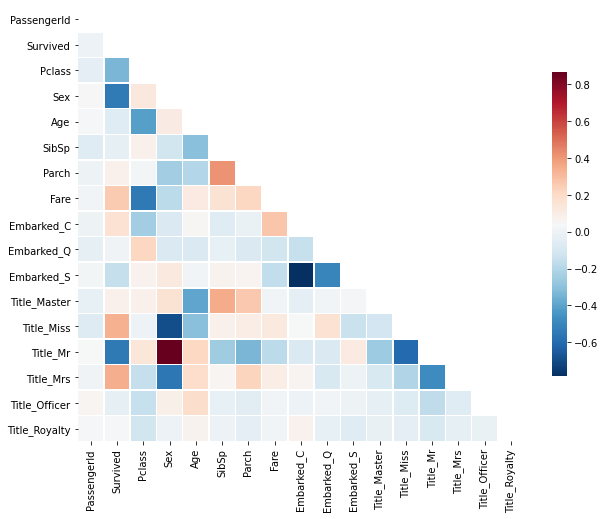

In [41]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='RdBu_r', linewidths=.5, cbar_kws={'shrink': .7})
plt.show()

If we just focus on the 'Survived' variable, we will notice that:
* It has a comparatively strong negative correlation with 'Pclass', 'Sex' and 'Title_Mr'
* It has a comparatively strong positive correlation with 'Fare', 'Embarked_C', 'Title_Miss' and 'Title_Mrs'

# 5. Model Building & Evaluation <a id="heading5"></a>

Before we can start building the machine learning models, we need to apply feature scaling to standardize the independent variables within a particular range. This is required because some machine learning algorithms (such as kNN) tend to give more weightage to features with high magnitudes than features with low magnitudes, regardless of the unit of the values. To bring all features to the same level of magnitudes, we need to apply feature scaling.

In this case, we will use the MinMaxScaler to scale each feature to a (0, 1) range.

In [42]:
# Apply feature scaling using MinMaxScaler
scaler = MinMaxScaler()
train_data.iloc[:, 2:] = scaler.fit_transform(train_data.iloc[:, 2:])
test_data.iloc[:, 1:] = scaler.transform(test_data.iloc[:, 1:])

ValueError: operands could not be broadcast together with shapes (891,16) (15,) (891,16) 

This is how the dataset looks like after feature scaling (remember, we only need to scale predictor variables):

In [43]:
train_data.head()

PassengerId  Survived  Pclass  Sex       Age  SibSp  Parch      Fare  \
0            1         0     1.0  1.0  0.271174  0.125    0.0  0.014151   
1            2         1     0.0  0.0  0.472229  0.125    0.0  0.139136   
2            3         1     1.0  0.0  0.321438  0.000    0.0  0.015469   
3            4         1     0.0  0.0  0.434531  0.125    0.0  0.103644   
4            5         0     1.0  1.0  0.434531  0.000    0.0  0.015713   

   Embarked_C  Embarked_Q  Embarked_S  Title_Master  Title_Miss  Title_Mr  \
0         0.0         0.0         1.0           0.0         0.0       1.0   
1         1.0         0.0         0.0           0.0         0.0       0.0   
2         0.0         0.0         1.0           0.0         1.0       0.0   
3         0.0         0.0         1.0           0.0         0.0       0.0   
4         0.0         0.0         1.0           0.0         0.0       1.0   

   Title_Mrs  Title_Officer  Title_Royalty  
0        0.0            0.0            0.0  
1        1.0            0.0            0.0  
2        0.0            0.0            0.0  
3        1.0            0.0            0.0  
4        0.0            0.0            0.0

Next, we will split our train and test datasets with respect to predictor (X) and response (y) variables.

In [51]:
X_train, X_test, y_train = train_data.iloc[:, 2:], test_data.iloc[:, 1:], train_data['Survived']

The 'y_test' is not provided in this dataset. For getting the test scores, we will have to submit our predictions online. To make the entire process a bit smoother, we will write a function that takes in model predictions and generates a file in the required format to submit online.

In [52]:
# Function to generate submission file to get test score
def submission(preds):
    test_data['Survived'] = preds
    predictions = test_data[['PassengerId', 'Survived']]
    predictions.to_csv('submission.csv', index=False)

Now, we can finally start building machine learning models to predict which of the passengers survived.

## 5.1 Logistic Regression <a id="subheading1"></a>

Important parameters that we will tune:
* penalty: Used to specify the norm used in the penalization
* C: Inverse of regularization strength

For hyperparameter tuning, we will use grid search cross validation over the specified parameter values. We will repeat 5-fold cross validation 10 times so that we can further improve the model performance and reduce overfitting. This will lead to better results for test/unseen data.

In [53]:
# Classification model
logreg = LogisticRegression()

# Parameters to tune
params = [{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
           'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

# Hyperparameter tuning using GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)
lr_clf = GridSearchCV(logreg, params, cv=cv, n_jobs=-1)
lr_clf.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=101),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none']}])

In [54]:
# Best parameters
lr_clf.best_params_

{'C': 10, 'penalty': 'l2'}

In [55]:
# Train score
lr_clf.best_score_

0.8273236843775789

The train accuracy is 82.7%.

In [56]:
# Test score
y_preds = lr_clf.predict(X_test)
submission(y_preds)

ValueError: X has 16 features per sample; expecting 15

After submission, the test accuracy is found to be 76.8%

## 5.2 Gaussian Naive Bayes <a id="subheading2"></a>

Using default parameters.

In [57]:
# Classification model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [58]:
# Test score
y_preds = gnb.predict(X_test)
submission(y_preds)

ValueError: operands could not be broadcast together with shapes (891,16) (15,) 

After submission, the test accuracy is found to be 75.1%.

## 5.3 Linear Discriminant Analysis (LDA) <a id="subheading3"></a>

Using default parameters.

In [59]:
# Classification model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [60]:
# Test score
y_preds = lda.predict(X_test)
submission(y_preds)

ValueError: X has 16 features per sample; expecting 15

After submission, the test accuracy is found to be 77.5%.

## 5.4 k Nearest Neighbors (kNN) <a id="subheading4"></a>

Important parameters that we will tune:
* n_neighbors: Number of neighbors to use
* p: For choosing between manhattan distance and euclidean distance metrics

In [61]:
# Classification model
knn = KNeighborsClassifier()

# Parameters to tune
params = [{'n_neighbors': range(1, 21),
           'p': [1, 2]}]

# Hyperparameter tuning using GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)
knn_clf = GridSearchCV(knn, params, cv=cv, n_jobs=-1)
knn_clf.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=101),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': range(1, 21), 'p': [1, 2]}])

In [62]:
# Best parameters
knn_clf.best_params_

{'n_neighbors': 12, 'p': 1}

In [63]:
# Train score
knn_clf.best_score_

0.8214771789500412

The train accuracy is 82.1%.

In [64]:
# Test score
y_preds = knn_clf.predict(X_test)
submission(y_preds)

ValueError: query data dimension must match training data dimension

After submission, the test accuracy is found to be 77.3%.

## 5.5 Support Vector Machine (SVM) <a id="subheading5"></a>

Important parameters that we will tune:
* C: Penalty parameter for determining the trade-off between setting a larger margin and lowering misclassification
* kernel: Specifies the kernel type to be used in the algorithm

In [65]:
# Classification model
svm = SVC(max_iter=10000)

# Parameters to tune
params = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
           'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

# Hyperparameter tuning using GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)
svm_clf = GridSearchCV(svm, params, cv=cv, n_jobs=-1)
svm_clf.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=101),
             estimator=SVC(max_iter=10000), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}])

In [66]:
# Best parameters
svm_clf.best_params_

{'C': 1, 'kernel': 'poly'}

In [67]:
# Train score
svm_clf.best_score_

0.8284548974798451

The train accuracy is 82.8%.

In [68]:
# Test score
y_preds = svm_clf.predict(X_test)
submission(y_preds)

ValueError: X.shape[1] = 16 should be equal to 15, the number of features at training time

After submission, the test accuracy is found to be 77.8%.

## 5.6 Decision Tree <a id="subheading6"></a>

Important parameters that we will tune:
* max_depth: Maximum depth of the tree
* min_samples_split: Minimum number of samples required to split an internal node
* max_features: Number of features to consider when looking for the best split

In [69]:
# Classification model
dt = DecisionTreeClassifier(random_state=seed)

# Parameters to tune
params = [{'max_depth': [5, 7, 10, None],
           'min_samples_split': [2, 5, 10],
           'max_features': ['sqrt', 5, 7, 10]}]

# Hyperparameter tuning using GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)
dt_clf = GridSearchCV(dt, params, cv=cv, n_jobs=-1)
dt_clf.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=101),
             estimator=DecisionTreeClassifier(random_state=101), n_jobs=-1,
             param_grid=[{'max_depth': [5, 7, 10, None],
                          'max_features': ['sqrt', 5, 7, 10],
                          'min_samples_split': [2, 5, 10]}])

In [70]:
# Best parameters
dt_clf.best_params_

{'max_depth': 5, 'max_features': 5, 'min_samples_split': 2}

In [71]:
# Train score
dt_clf.best_score_

0.8161994540722403

The train accuracy is 81.6%.

In [ ]:
# Test score
y_preds = dt_clf.predict(X_test)
submission(y_preds)

After submission, the test accuracy is found to be 78%.

## 5.7 Random Forest <a id="subheading7"></a>

Important parameters that we will tune:
* n_estimators: Number of trees in the forest
* max_depth: Maximum depth of the tree
* min_samples_split: Minimum number of samples required to split an internal node
* max_features: Number of features to consider when looking for the best split

In [ ]:
# Note: This cell will take a while to run depending on the available processing power

# Classification model
rf = RandomForestClassifier(random_state=seed)

# Parameters to tune
params = [{'n_estimators': range(50, 550, 50),
           'max_depth': [5, 7, 10, None],
           'min_samples_split': [2, 5, 10],
           'max_features': ['sqrt', 5, 7, 10]}]

# Hyperparameter tuning using GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)
rf_clf = GridSearchCV(rf, params, cv=cv, n_jobs=-1)
rf_clf.fit(X_train, y_train)

In [ ]:
# Best parameters
rf_clf.best_params_

In [ ]:
# Train score
rf_clf.best_score_

The train accuracy is 83.7%.

In [68]:
# Test score
y_preds = rf_clf.predict(X_test)
submission(y_preds)

After submission, the test accuracy is found to be 77%.

## 5.8 XGBoost <a id="subheading8"></a>

Important parameters that we will tune:
* max_depth: Maximum depth of the tree
* learning_rate: Controls the contribution of each tree
* n_estimators: Number of trees

In [ ]:
# Note: This cell will take a while to run depending on the available processing power

# Classification model
xgboost = xgb.XGBClassifier(random_state=seed)

# Parameters to tune
params = [{'max_depth': [3, 5, 10],
           'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
           'n_estimators': range(100, 1100, 100)}]

# Hyperparameter tuning using GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)
xgb_clf = GridSearchCV(xgboost, params, cv=cv, n_jobs=-1)
xgb_clf.fit(X_train, y_train)

In [ ]:
# Best parameters
xgb_clf.best_params_

In [ ]:
# Train score
xgb_clf.best_score_

The train accuracy is 82.9%.

In [72]:
# Test score
y_preds = xgb_clf.predict(X_test)
submission(y_preds)

After submission, the test accuracy is found to be 76.8%.

## 5.9 Model Stacking <a id="subheading9"></a>

In this part, we will stack all of our best performing models using the stacking classifier. Predictions generated by various models will be optimally combined to form a new set of predictions. (Note: The new predictions may not always give better result than the individual models).

Using default parameters.

In [73]:
# Models that we will input to stacking classifier
base_estimators = list()
base_estimators.append(('lda', lda))
base_estimators.append(('knn', knn_clf.best_estimator_))
base_estimators.append(('svm', svm_clf.best_estimator_))
base_estimators.append(('dt', dt_clf.best_estimator_))
base_estimators.append(('rf', rf_clf.best_estimator_))

# Stacking classifier
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lda', LinearDiscriminantAnalysis()),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=12, p=1)),
                               ('svm', SVC(C=1, kernel='poly', max_iter=10000)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       max_features=5,
                                                       random_state=101)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       max_features=10,
                                                       min_samples_split=10,
                                                       n_estimators=300,
                                                       random_state=101))],
                   final_estimator=LogisticRegressio

In [74]:
# Test score
y_preds = stacking_clf.predict(X_test)
submission(y_preds)

After submission, the test accuracy is found to be 78%.

## 5.10 Result Comparison <a id="subheading10"></a>


| Model | Train Accuracy (%) | Test Accuracy (%) |
| ----- | ------------------ | ----------------- |
| Logistic Regression | 82.7 | 76.8 |
| Gaussian Naive Bayes | N/A | 75.1 |
| Linear Discriminant Analysis | N/A | 77.5 |
| k Nearest Neighbors | 82.1 | 77.3 |
| Support Vector Machine | 82.8| 77.8 |
| Decision Tree | 81.6 | 78 |
| Random Forest | 83.7 | 77 |
| XGBoost | 82.9 | 76.8 |
| Model Stacking | N/A | 78 |

Looking at the above table, we can observe the following:
* Random Forest gave the highest train accuracy of 83.7%
* Decision Tree and Stacking Classifier performed best for test/unseen data with an accuracy of 78%
* Most of the models performed really similar in terms of test accuracy
* Due to the small dataset size, all models have (slightly) overfitted the train data, giving lower test scores than expected

# 6. Conclusion <a id="heading6"></a>

This notebook gave a brief overview of how different steps are performed in a data science project life cycle. We started by reading in the dataset, preprocessing it, exploring it to find useful insights, and finally built various machine learning models and evaluated them. The main objective of this project was to analyze the titanic dataset and predict whether a passenger will survive or not, based on various input features. To further build and improve upon this project, a lot of techniques could be tried.

Innovative ways of feature engineering like combining the 'SibSp' and 'Parch' features, or applying different data preprocessing methods such as binning the 'Age' column could be tried to help improve the overall performance. One technique that will surely improve the scores is to further hypertune the models. Due to limited time and processing power available, we only performed grid search over a few combinations of paramters' values (we also skipped many parameters and used their default value). The extra time spent on tuning the parameters usually leads to better results.

Additionally, there are other options for trying and improving the prediction accuracy such as applying feature selection techniques or building deep learning models (e.g. neural networks). Part of a job of data scientists is to be creative, keep experimenting and try figuring out new ways of improving upon their work. The 'titanic survival prediction' task is no exception.

## Fairness

In [44]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [45]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [46]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [47]:
train_data.head()

PassengerId  Survived  Pclass  Sex       Age  SibSp  Parch      Fare  \
0            1         0     1.0  1.0  0.271174  0.125    0.0  0.014151   
1            2         1     0.0  0.0  0.472229  0.125    0.0  0.139136   
2            3         1     1.0  0.0  0.321438  0.000    0.0  0.015469   
3            4         1     0.0  0.0  0.434531  0.125    0.0  0.103644   
4            5         0     1.0  1.0  0.434531  0.000    0.0  0.015713   

   Embarked_C  Embarked_Q  Embarked_S  Title_Master  Title_Miss  Title_Mr  \
0         0.0         0.0         1.0           0.0         0.0       1.0   
1         1.0         0.0         0.0           0.0         0.0       0.0   
2         0.0         0.0         1.0           0.0         1.0       0.0   
3         0.0         0.0         1.0           0.0         0.0       0.0   
4         0.0         0.0         1.0           0.0         0.0       1.0   

   Title_Mrs  Title_Officer  Title_Royalty  
0        0.0            0.0            0.0  
1        1.0            0.0            0.0  
2        0.0            0.0            0.0  
3        1.0            0.0            0.0  
4        0.0            0.0            0.0

In [48]:
#print(X)


#combine_final = [train_df, test_df]
#result = pd.concat(combine_final)
#print(result.ifany())
#print(result)
privileged_groups = [{'Sex': 0}]
unprivileged_groups = [{'Sex': 1}]
dataset_orig = StandardDataset(train_data,
                                  label_name='Survived',
                                  protected_attribute_names=['Sex'],
                                  favorable_classes=[1],
                                  privileged_classes=[[0]])


In [49]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.551476


In [ ]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

import pickle

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

# Models that we will input to stacking classifier
base_estimators = list()
base_estimators.append(('lda', lda))
base_estimators.append(('knn', knn_clf.best_estimator_))
base_estimators.append(('svm', svm_clf.best_estimator_))
base_estimators.append(('dt', dt_clf.best_estimator_))
base_estimators.append(('rf', rf_clf.best_estimator_))

# Stacking classifier
model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

mdl = model.fit(X_train, y_train)
with open('../../Results/Stacking/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/Stacking/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/Stacking/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [ ]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in base_estimators:
    
    list_estimators.append((name,ml_model))
    #print(list_estimators)
    model = StackingClassifier(estimators = base_estimators, verbose =1)
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    final_metrics.append(fair_list)


In [ ]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(len(list_estimators) - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/Stacking/' + nb_fname + '.csv')
final_result